In [1]:
from astropy import units as u, utils
from astropy.coordinates import SkyCoord
from astropy import wcs
from astropy.nddata import Cutout2D
from astropy.io import fits
from matplotlib import gridspec as gridspec, lines as mlines, pyplot as plt
from matplotlib.colorbar import Colorbar
import numpy as np
import pyvo as vo
import scipy.ndimage
import aplpy
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [2]:
from __future__ import division
import glob
import re
import os, sys
from astropy.io.fits import getheader, getdata
from astropy.wcs import WCS
import astropy.units as u
import numpy as np
from scipy import interpolate
import logging
from time import time
import matplotlib.pyplot as plt
from pylab import *
import matplotlib as mpl
import matplotlib.ticker as mtick
from scipy.special import gamma

In [3]:
from astroquery.sdss import SDSS

C:\ProgramData\Anaconda2\lib\site-packages\astroquery\sdss\__init__.py:29: UserWarning: Experimental: SDSS has not yet been refactored to have its API match the rest of astroquery (but it's nearly there).
  warnings.warn("Experimental: SDSS has not yet been refactored to have its API "


In [4]:
import photutils

In [5]:
import copy
from matplotlib.colors import LogNorm

In [6]:
def make_obj(flux, grat_wave, f_lam_index):
        '''
        '''
        w = 5000
        p_A = flux/(2.e-8/w)*(w/grat_wave)**f_lam_index

        return w, p_A

def inst_throughput(wave, grat):
        '''
        '''
        eff_bl   = np.asarray([0.1825,0.38,0.40,0.46,0.47,0.44])
        eff_bm   = np.asarray([0.1575, 0.33, 0.36, 0.42, 0.48, 0.45])
        eff_bh1  = np.asarray([0., 0.0, 0.0, 0.0, 0.0, 0.])
        eff_bh2  = np.asarray([0.,  0.18, 0.3, 0.4, 0.28, 0.])
        eff_bh3  = np.asarray([0., 0., 0., 0.2, 0.29, 0.31])
        wave_0   = np.asarray([355.,380.,405.,450.,486.,530.])*10.
        wave_bl  = np.asarray([355., 530.])*10.
        wave_bm  = np.asarray([355., 530.])*10.
        wave_bh1 = np.asarray([350., 450.])*10.
        wave_bh2 = np.asarray([405., 486.])*10.
        wave_bh3 = np.asarray([405., 530.])*10.
        trans_atmtel = np.asarray([0.54, 0.55, 0.56, 0.56, 0.56, 0.55])

        if grat=='BL':
                eff = eff_bl*trans_atmtel
                wave_range = wave_bl

        if grat=='BM':
                eff = eff_bm*trans_atmtel
                wave_range = wave_bm

        if grat=='BH1':
                eff = eff_bh1*trans_atmtel
                wave_range = wave_bh1

        if grat=='BH2':
                eff = eff_bh2*trans_atmtel
                wave_range = wave_bh2

        if grat=='BH3':
                eff = eff_bh3*trans_atmtel
                wave_range = wave_bh3


        wave1 = np.ones(5000)*5000
        interpfunc = interpolate.interp1d(wave_0, eff, fill_value="extrapolate") #this is the only way I've gotten this interpolation to work
        eff_int = interpfunc(wave1)
        idx = np.where((wave1 <= wave_range[0]) | (wave1 > wave_range[1]))
        eff_int[idx] = 0.
        return eff_int[0]



def obj_cts(w, f0, grat, exposure_time):
        '''
        '''
        A_geo = np.pi/4.*(10.e2)**2
        eff = inst_throughput(w, grat)
        cts = eff*A_geo*exposure_time*f0
        return cts

def sky(wave):
        '''
        '''
        with open('mk_sky.dat') as f:
                lines = (line for line in f if not line.startswith('#'))
                skydata = np.loadtxt(lines, skiprows=2)

        ws = skydata[:,0]
        fs = skydata[:,1]
        f_nu_data = getdata('lris_esi_skyspec_fnu_uJy.fits')
        f_nu_hdr = getheader('lris_esi_skyspec_fnu_uJy.fits')
        dw = f_nu_hdr["CDELT1"]
        w0 = f_nu_hdr["CRVAL1"]
        ns = len(fs)
        ws = np.arange(ns)*dw + w0
        f_lam = f_nu_data[:len(ws)]*1e-29*3.*1e18/ws/ws

        interpfunc = interpolate.interp1d(ws,f_lam, fill_value="extrapolate")
        fs_int = interpfunc(wave)
        return fs_int

def sky_mk(wave):
        '''
        '''
        with open('mk_sky.dat') as f:
                lines = (line for line in f if not line.startswith('#'))
                skydata = np.loadtxt(lines, skiprows=2)

        ws = skydata[:,0]
        fs = skydata[:,1]
        f_nu_data = getdata('lris_esi_skyspec_fnu_uJy.fits')
        f_nu_hdr = getheader('lris_esi_skyspec_fnu_uJy.fits')
        dw = f_nu_hdr["CDELT1"]
        w0 = f_nu_hdr["CRVAL1"]
        ns = len(fs)
        ws = np.arange(ns)*dw + w0
        f_lam = f_nu_data[:len(ws)]*1e-29*3.*1e18/ws/ws
        p_lam = f_lam/(2.e-8/ws)

        interpfunc = interpolate.interp1d(ws,p_lam, fill_value="extrapolate") #using linear since argument not set in idl
        ps_int = interpfunc(wave)
        return ps_int

def sky_cts(w, grat, exposure_time, airmass=1.2, area=1.0):
        '''
        '''
        A_geo = np.pi/4.*(10.e2)**2
        eff = inst_throughput(w, grat)
        cts = eff*A_geo*exposure_time*sky_mk(w)*airmass*area
        return cts

In [7]:
def ETC(slicer, grating, grat_wave, f_lam_index, seeing, exposure_time, ccd_bin, spatial_bin=[],
        spectral_bin=None, nas=True, sb=True, mag_AB=None, flux=None, Nframes=1, emline_width=None):


        """
                Parameters
                ==========
            slicer: str
                      L/M/S (Large, Medium or Small)
            grating: str
                      BH1, BH2, BH3, BM, BL
            grating wavelength: float or int
                      3400. < ref_wave < 6000.
                f_lam_index: float
                      source f_lam ~ lam^f_lam_index, default = 0
            seeing: float
                      arcsec
            exposure_time: float
                  seconds for source image (total) for all frames
                ccd_bin: str
                      '1x1','2x2'"
            spatial_bin: list
                      [dx,dy] bin in arcsec x arcsec for binning extended emission flux. if sb=True then default is 1 x 1 arcsec^2'
                spectral_bin: float or int
                      Ang to bin for S/N calculation, default=None
            nas: boolean
                      nod and shuffle
            sb: boolean
                    surface brightness m_AB in mag arcsec^2; flux = cgs arcsec^-2'
            mag_AB: float or int
                      continuum AB magnitude at wavelength (ref_wave)'
                flux: float
                      erg cm^-2 s^-1 Ang^1 (continuum source [total]); erg cm^-2 s^1 (point line source [total]) [emline = width in Ang]
                  EXTENDED: erg cm^-2 s^-1 Ang^1 arcsec^-2 (continuum source [total]); erg cm^-2 s^1 arcsec^-2 (point line source [total]) [emline = width in Ang]
            Nframes: int
                      number of frames (default is 1)
            emline_width: float
                      flux is for an emission line, not continuum flux (only works for flux), and emission line width is emline_width Ang

    """
        logger = logging.getLogger(__name__)
        logger.info('Running KECK/ETC')
        t0 = time()
        slicer_OPTIONS = ('L', 'M','S')
        grating_OPTIONS = ('BH1', 'BH2', 'BH3', 'BM', 'BL')

        if slicer not in slicer_OPTIONS:
                raise ValueError("slicer must be L, M, or S, wrongly entered {}".format(slicer))
        logger.info('Using SLICER=%s', slicer)

        if grating not in grating_OPTIONS:
                raise ValueError("grating must be L, M, or S, wrongly entered {}".format(grating))
        logger.info('Using GRATING=%s', grating)

        if grat_wave < 3400. or grat_wave > 6000:
                raise ValueError('wrong value for grating wavelength')
        logger.info('Using reference wavelength=%.2f', grat_wave)

        if len(spatial_bin) != 2 and len(spatial_bin) !=0:
                raise ValueError('wrong spatial binning!!')
        logger.info('Using spatial binning, spatial_bin=%s', str(spatial_bin[0])+'x'+str(spatial_bin[1]))


        bin_factor = 1.
        if ccd_bin == '2x2':
                bin_factor = 0.25
        if ccd_bin == '2x2' and slicer == 'S':
                print'******** WARNING: DO NOT USE 2x2 BINNING WITH SMALL SLICER'
        read_noise = 2.7 # electrons
        Nf = Nframes

        chsz = 3 #what is this????
        nas_overhead = 10. #seconds per half cycle
        seeing1 = seeing
        seeing2 = seeing
        pixels_per_arcsec = 1./0.147
        if slicer == 'L':
                seeing2 = 1.38
        snr_spatial_bin = seeing1*seeing2
        pixels_spectral = 8
        arcsec_per_slice = 1.35

        if slicer == 'M':
                seeing2 = max(0.69,seeing)
                snr_spatial_bin = seeing1*seeing2
                pixels_spectral = 4
                arcsec_per_slice = 0.69
        if slicer == 'S':
                seeing2 = seeing
                snr_spatial_bin = seeing1*seeing2
                pixels_spectral = 2
                arcsec_per_slice = 0.35

        N_slices = seeing/arcsec_per_slice

        if len(spatial_bin) == 2:
                N_slices = spatial_bin[1]/arcsec_per_slice
                snr_spatial_bin = spatial_bin[0]*spatial_bin[1]

        pixels_spatial_bin = pixels_per_arcsec * N_slices
#         print "GRATING :", grating

        if grating == 'BL':
                A_per_pixel = 0.625

        if grating == 'BM':
                A_per_pixel = 0.28

        if grating == 'BH2' or grating == 'BH3':
                A_per_pixel = 0.125

#         print 'A_per_pixel', A_per_pixel

        logger.info('f_lam ~ lam = %.2f',f_lam_index)
        logger.info('SEEING: %.2f, %s', seeing, ' arcsec')
        logger.info('Ang/pixel: %.2f', A_per_pixel)
        logger.info('spectral pixels in 1 spectral resolution element: %.2f',pixels_spectral)

        A_per_spectral_bin = pixels_spectral*A_per_pixel

        logger.info('Ang/resolution element: =%.2f',A_per_spectral_bin)

        if spectral_bin is not None:
                snr_spectral_bin = spectral_bin
        else:
                snr_spectral_bin = A_per_spectral_bin

        logger.info('Ang/SNR bin: %.2f', snr_spectral_bin)
        pixels_per_snr_spec_bin = snr_spectral_bin/A_per_pixel
        logger.info('Pixels/Spectral SNR bin: %.2f', pixels_per_snr_spec_bin)
        logger.info('SNR Spatial Bin [arcsec^2]: %.2f', snr_spatial_bin)
        logger.info('SNR Spatial Bin [pixels^2]: %.2f', pixels_spatial_bin)

        flux1 = 0
        if flux is not None:
           flux1 = flux
        if flux is not None and emline_width is not None:
           flux1 = flux/emline_width
        if flux1 == 0 and emline_width is not None:
                raise ValueError('Dont use mag_AB for emission line')

        if mag_AB is not None:
                flux1 = (10**(-0.4*(mag_AB+48.6)))*(3.e18/grat_wave)/grat_wave

        w, p_A = make_obj(flux1,grat_wave, f_lam_index)

        if sb==False and mag_AB is not None:
                flux_input = ' mag_AB'
                logger.info('OBJECT mag: %.2f, %s', mag_AB,flux_input)

        if sb==True and mag_AB is not None:
                flux_input = ' mag_AB / arcsec^2'
                logger.info('OBJECT mag: %.2f, %s',mag_AB,flux_input)


        if flux is not None and sb==False and emline_width is None:
                flux_input = 'erg cm^-2 s^-1 Ang^-1'
        if flux is not None and sb==False and emline_width is not None:
                flux_input = 'erg cm^-2 s^-1 in '+ str(emline_width) +' Ang'
        if flux is not None and sb and emline_width is None:
                flux_input = 'erg cm^-2 s^-1 Ang^-1 arcsec^-2'
        if flux is not None and sb and emline_width is not None:
                flux_input = 'erg cm^-2 s^-1 arcsec^-2 in '+ str(emline_width) +' Ang'
        if flux is not None:
            logger.info('OBJECT Flux  %.2f, %s',flux,flux_input)
        if emline_width is not None:
                logger.info('EMISSION LINE OBJECT --> flux is not per unit Ang')


        t_exp = exposure_time
        if nas==False:
                c_o = obj_cts(w,p_A,grating,t_exp)*snr_spatial_bin*snr_spectral_bin
                c_s = sky_cts(w,grating,exposure_time,airmass=1.2,area=1.0)*snr_spatial_bin*snr_spectral_bin
                c_r = Nf*read_noise**2*pixels_per_snr_spec_bin*pixels_spatial_bin*bin_factor
                snr = c_o/np.sqrt(c_s+c_o+c_r)


        if nas==True:
                n_cyc = np.floor((exposure_time-nas_overhead)/2./(nas+nas_overhead)+0.5)
                total_exposure = (2*n_cyc*(nas+nas_overhead))+nas_overhead
                logger.info('NAS: Rounding up to ',n_cyc, ' Cycles of NAS for total exposure of',total_exposure,' s')
                t_exp = n_cyc*nas
                c_o = obj_cts(w,p_A,grating,t_exp)*snr_spatial_bin*snr_spectral_bin
                c_s = sky_cts(w,grating,t_exp,airmass=1.2,area=1.0)*snr_spatial_bin*snr_spectral_bin
                c_r = 2.*Nf*read_noise**2*pixels_per_snr_spec_bin*pixels_spatial_bin*bin_factor
                snr = c_o/np.sqrt(2.*c_s+c_o+c_r)
        return snr

In [8]:
def calc_mag(sf_bright):
    '''
    Takes surface brightness data that is in units of
    nanomaggies and calculates magnitude
    '''
    m = 22.5 - 2.5 * np.log10(sf_bright)
    u = m + 2.5 * np.log10(0.16)
    return u

In [9]:
def get_fits(RA, DEC, frame='icrs', band='g'):
    '''
    Call astroquery to retrieve SDSS fits image at specified coordinates and band.
    '''


    image = SDSS.get_images(coordinates=SkyCoord(RA*u.deg, DEC*u.deg, frame='icrs'), band=band)
    return image


def rebin(data, factor=2):
    '''
    Rebin data.
    '''

    # Our data may not be the right dimensions to do a clean rebin.
    # We will remove some rows or columns to make a clean binning.
    
    # row_cut and column_cut variables will help keep track of how many rows and columns we cut.
    row_cut = 0
    column_cut = 0
    while data.shape[0] % factor != 0:
        data = data[:-1,:]
        row_cut += 1
    while data.shape[1] % factor != 0:
        data = data[:,:-1]
        column_cut += 1
    if row_cut != 0:
        print "Lost {} rows from initial data array.".format(row_cut)
    if column_cut != 0:
        print "Lost {} columns from initial data array.".format(column_cut)

    shaper = (data.shape[0]//factor,
              data.shape[0]//(data.shape[0]//factor),
              data.shape[1]//factor,
              data.shape[1]//(data.shape[1]//factor))
    rebinned_data = data.reshape(shaper).mean(-1).mean(1)
    print "Bin count reduced from {} bins to {} bins.".format(data.shape[0] * data.shape[1],
                                                              rebinned_data.shape[0] * rebinned_data.shape[1])
    return rebinned_data


def plot_coords(RA, DEC, frame='icrs', band='g', vmaxpercent=99):
    '''
    Call astroquery to retrieve SDSS fits image at specified coordinates and band,
    and then automatically plot this image.
    '''


    image = get_fits(RA, DEC, frame=frame, band=band)
    plt.imshow(image[0][0].data,
               vmax=np.percentile(image[0][0].data, vmaxpercent),
               cmap='gray')
    plt.show()

def annulizer(data, target_row, target_col,
              slicer, grating, grat_wave, f_lam_index, seeing,
              exposure_time, ccd_bin, spatial_bin=[],
              spectral_bin=None, nas=True, sb=True, mag_AB=None,
              flux=None, Nframes=1, emline_width=None):

    hive = []
    for step in range(max(data.shape[0]-target_row,
                          data.shape[1]-target_col,
                          data.shape[0]-2,
                          data.shape[1]-2)):
        ring = []
        for i in range(-step,step+1):
            if i == -step or i == step:
                for j in range(-step,step+1):
                    if target_row+i >= 0 and target_col+j >= 0:
                        try:
                            ring.append(data[target_row+i][target_col+j])
                        except IndexError:
                            pass
            else:
                for j in (-step, step):
                    if target_row+i >= 0 and target_col+j >= 0:
                        try:
                            ring.append(data[target_row+i][target_col+j])
                        except IndexError:
                            pass
        hive.append(ETC(slicer='S', grating='BL',
                        grat_wave=5110., f_lam_index=0.,
                        seeing=0.75, exposure_time=3600.,
                        ccd_bin='1x1',
                        spatial_bin=[0.4,0.4],
                        spectral_bin=None,
                        nas=False, sb=True,
                        mag_AB=np.mean(ring), flux=None,
                        Nframes=1, emline_width=None))

    for step in range(max(data.shape[0]-target_row,
                          data.shape[1]-target_col,
                          data.shape[0]-2,
                          data.shape[1]-2)):
        for i in range(-step,step+1):
            if i == -step or i == step:
                for j in range(-step,step+1):
                    if target_row+i >= 0 and target_col+j >= 0:
                        try:
                            data[target_row+i][target_col+j] = hive[step]
                        except IndexError:
                            pass
            else:
                for j in (-step, step):
                    if target_row+i >= 0 and target_col+j >= 0:
                        try:
                            data[target_row+i][target_col+j] = hive[step]
                        except IndexError:
                            pass
    return data

In [141]:
def STON2D(RA, DEC, frame='icrs', band='g',
           framesize=1, factor=None,
           slicer='S', grating='BL',
           grat_wave=5110., f_lam_index=0.,
           seeing=0.75, exposure_time=3600.,
           ccd_bin='1x1',
           spatial_bin=[0.4,0.4],
           spectral_bin=None,
           nas=False, sb=True,
           flux=None,
           Nframes=1, emline_width=None):
    
    im = get_fits(RA=RA, DEC=DEC, band=band)
    center = SkyCoord(RA*u.deg, DEC*u.deg, frame=frame)
    w = wcs.WCS(im[0][0].header)
    co = Cutout2D(im[0][0].data, center,
                  size=[framesize,framesize]*u.arcmin,
                  wcs=w)

    if factor is not None:
        co.data = rebin(co.data, factor)

    brt = calc_mag(co.data)
    brt[np.isnan(brt)] = np.nanmin(brt)
    
    anbrt = annulizer(copy.deepcopy(brt),
                      shape(brt)[0]//2, shape(brt)[1]//2,
                      slicer=slicer, grating=grating,
                      grat_wave=grat_wave, f_lam_index=f_lam_index,
                      seeing=seeing, exposure_time=exposure_time,
                      ccd_bin=ccd_bin, spatial_bin=spatial_bin,
                      spectral_bin=spectral_bin, nas=nas, sb=sb,
                      flux=flux, Nframes=Nframes,
                      emline_width=emline_width)

    height_ratios = [5]
    width_ratios = [5, .75, 5]
    wspace, hspace = .25, 0
    fig = plt.figure(figsize=(sum(width_ratios) + wspace * (len(width_ratios) - 1),
                              sum(height_ratios) + hspace * (len(height_ratios) - 1)))
    gs = gridspec.GridSpec(len(height_ratios), len(width_ratios),
                           height_ratios=height_ratios, width_ratios=width_ratios)
    ax = fig.add_subplot(gs[0,0])
    ax.set_title('SDSS Image')
    ax.set_xlabel('RA')
    ax.set_ylabel('DEC')
    ax.spines["top"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    ax.spines["left"].set_visible(False)
    ax.spines["right"].set_visible(False)
    sfb_plt = ax.imshow(co.data, cmap='RdBu')
    
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    sfb_cb = Colorbar(ax=cax, mappable=sfb_plt, ticklocation='right')
    sfb_cb.set_label('Nanomaggies', labelpad=10)
    
    ax = fig.add_subplot(gs[0,2])
    ax.set_title('Annulized STON')
    ax.set_xlabel('RA')
    ax.set_ylabel('DEC')
    ax.spines["top"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    ax.spines["left"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ston_plt = ax.imshow(anbrt, cmap='RdBu')
    
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    ston_cb = Colorbar(ax=cax, mappable=ston_plt, ticklocation='right')
    ston_cb.set_label('Signal to Noise', labelpad=10)
    
    plt.show()

In [153]:
def STON2D(RA, DEC, frame='icrs', band='g',
           framesize=1, factor=None,
           slicer='S', grating='BL',
           grat_wave=5110., f_lam_index=0.,
           seeing=0.75, exposure_time=3600.,
           ccd_bin='1x1',
           spatial_bin=[0.4,0.4],
           spectral_bin=None,
           nas=False, sb=True,
           flux=None,
           Nframes=1, emline_width=None):
    
    im = get_fits(RA=RA, DEC=DEC, band=band)
    center = SkyCoord(RA*u.deg, DEC*u.deg, frame=frame)
    w = wcs.WCS(im[0][0].header)
    co = Cutout2D(im[0][0].data, center,
                  size=[framesize,framesize]*u.arcmin,
                  wcs=w)

    if factor is not None:
        co.data = rebin(co.data, factor)

    sf_bright = calc_mag(co.data)
    sf_bright[np.isnan(sf_bright)] = np.nanmin(sf_bright)
    
    elliptical = copy.deepcopy(sf_bright)
    bins = []
    bins.append(np.mean(sf_bright[(sf_bright > 9) & (sf_bright < 10)]))
    elliptical[(elliptical > 9) & (elliptical < 10)] = bins[0]
    bins.append(np.mean(sf_bright[(sf_bright > 8) & (sf_bright < 9)]))
    elliptical[(elliptical > 8) & (elliptical < 9)] = bins[1]
    bins.append(np.mean(sf_bright[(sf_bright > 7) & (sf_bright < 8)]))
    elliptical[(elliptical > 7) & (elliptical < 8)] = bins[2]
    bins.append(np.mean(sf_bright[(sf_bright > 6) & (sf_bright < 7)]))
    elliptical[(elliptical > 6) & (elliptical < 7)] = bins[3]
    bins.append(np.mean(sf_bright[(sf_bright > 5) & (sf_bright < 6)]))
    elliptical[(elliptical > 5) & (elliptical < 6)] = bins[4]
    bins.append(np.mean(sf_bright[(sf_bright > 4) & (sf_bright < 5)]))
    elliptical[(elliptical > 4) & (elliptical < 5)] = bins[5]
    bins.append(np.mean(sf_bright[(sf_bright > 3) & (sf_bright < 4)]))
    elliptical[(elliptical > 3) & (elliptical < 4)] = bins[6]
    bins.append(np.mean(sf_bright[(sf_bright > 2) & (sf_bright < 3)]))
    elliptical[(elliptical > 2) & (elliptical < 3)] = bins[7]
    bins.append(np.mean(sf_bright[(sf_bright > 1) & (sf_bright < 2)]))
    elliptical[(elliptical > 1) & (elliptical < 2)] = bins[8]
    bins.append(np.mean(sf_bright[(sf_bright > 0) & (sf_bright < 1)]))
    elliptical[(elliptical > 0) & (elliptical < 1)] = bins[9]
   
    m = 22.5 - 2.5 * np.log10(elliptical)
    U = m + 2.5 * np.log10(0.16)
    
    SNR = [[ETC(slicer=slicer, grating=grating,
               grat_wave=grat_wave, f_lam_index=f_lam_index,
               seeing=seeing, exposure_time=exposure_time,
               ccd_bin=ccd_bin, spatial_bin=spatial_bin,
               spectral_bin=spectral_bin, nas=nas, sb=sb,
               mag_AB = jval,
               flux=flux, Nframes=Nframes,
               emline_width=emline_width)
            for j, jval in enumerate(ival)]
           for i, ival in enumerate(U)]

    height_ratios = [5]
    width_ratios = [5, .75, 5]
    wspace, hspace = .25, 0
    fig = plt.figure(figsize=(sum(width_ratios) + wspace * (len(width_ratios) - 1),
                              sum(height_ratios) + hspace * (len(height_ratios) - 1)))
    gs = gridspec.GridSpec(len(height_ratios), len(width_ratios),
                           height_ratios=height_ratios, width_ratios=width_ratios)
    ax = fig.add_subplot(gs[0,0])
    ax.set_title('SDSS Image')
    ax.set_xlabel('RA')
    ax.set_ylabel('DEC')
    ax.spines["top"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    ax.spines["left"].set_visible(False)
    ax.spines["right"].set_visible(False)
    sfb_plt = ax.imshow(co.data, cmap='RdBu')
    
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    sfb_cb = Colorbar(ax=cax, mappable=sfb_plt, ticklocation='right')
    sfb_cb.set_label('Nanomaggies', labelpad=10)
    
    ax = fig.add_subplot(gs[0,2])
    ax.set_title('Annulized STON')
    ax.set_xlabel('RA')
    ax.set_ylabel('DEC')
    ax.spines["top"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    ax.spines["left"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ston_plt = ax.imshow(SNR, cmap='RdBu')
    
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    ston_cb = Colorbar(ax=cax, mappable=ston_plt, ticklocation='right')
    ston_cb.set_label('Signal to Noise', labelpad=10)
    
    plt.show()

C:\ProgramData\Anaconda2\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in log10
  


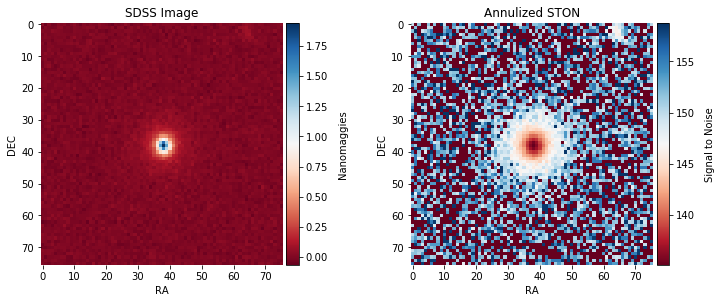

In [155]:
STON2D(RA=187.97039, DEC=12.26641, framesize=.5)

In [54]:
RA=187.97039
DEC=12.26641
framesize=5

im = get_fits(RA=RA, DEC=DEC, band='g')
center = SkyCoord(RA*u.deg, DEC*u.deg, frame='icrs')
w = WCS(im[0][0].header)
co = Cutout2D(im[0][0].data, center,
              size=[framesize,framesize]*u.arcmin,
              wcs=w)

In [99]:
coo = np.array([w.all_pix2world(x, y, 0)
                for x, y in zip(range(co.xmin_cutout, co.xmax_cutout),
                                range(co.ymin_cutout, co.ymax_cutout))])


In [128]:
w

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 187.98187755399999  12.273859575199999  
CRPIX : 1025.0  745.0  
CD1_1 CD1_2  : 1.2919322279499999e-06  0.000110021935548  
CD2_1 CD2_2  : 0.000109940156277  -1.2660468933799999e-06  
NAXIS : 2048  1489

In [102]:
coo[:,0]

array([ 187.8967887 ,  187.89690253,  187.89701636,  187.8971302 ,
        187.89724403,  187.89735787,  187.8974717 ,  187.89758554,
        187.89769937,  187.89781321,  187.89792704,  187.89804088,
        187.89815471,  187.89826855,  187.89838238,  187.89849622,
        187.89861005,  187.89872389,  187.89883773,  187.89895156,
        187.8990654 ,  187.89917923,  187.89929307,  187.89940691,
        187.89952074,  187.89963458,  187.89974842,  187.89986225,
        187.89997609,  187.90008993,  187.90020376,  187.9003176 ,
        187.90043144,  187.90054527,  187.90065911,  187.90077295,
        187.90088679,  187.90100062,  187.90111446,  187.9012283 ,
        187.90134214,  187.90145597,  187.90156981,  187.90168365,
        187.90179749,  187.90191133,  187.90202517,  187.902139  ,
        187.90225284,  187.90236668,  187.90248052,  187.90259436,
        187.9027082 ,  187.90282204,  187.90293588,  187.90304972,
        187.90316355,  187.90327739,  187.90339123,  187.90350

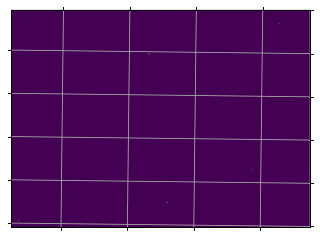

In [127]:
fig, ax = plt.subplots()

ax = plt.subplot(projection=w)
ax.imshow(im[0][0].data,origin='lower')

ax.tick_params(axis='both', which='both', labelsize=7)
ax.grid()
# dec = ax.coords[1]
# dec.set_major_formatter('dd:mm')
# dec.set_ticks([29.5, 30, 30.5, 31, 31.5, 32, 32.5, 33] *u.deg)
# dec.set_ticklabel(size=6)

plt.show()

In [ ]:
w

In [ ]:
lon, lat = w.all_pix2world(0, 0, 0)
lon, lat

In [ ]:
plt.colorbar?

In [ ]:
framesize=.5
factor = None
RA=187.97039
DEC=12.26641

im = get_fits(RA=RA, DEC=DEC, band='g')
w = wcs.WCS(im[0][0].header)

center = SkyCoord(RA*u.deg, DEC*u.deg, frame='icrs')
co = Cutout2D(im[0][0].data, center, size=[framesize,framesize]*u.arcmin, wcs=w)

if factor is not None:
    co.data = rebin(co.data, factor)

brt = calc_mag(co.data)
brt[np.isnan(brt)] = np.nanmin(brt)

anbrt = annulizer(copy.deepcopy(brt),
                  shape(brt)[0]//2,
                  shape(brt)[1]//2,
                  slicer='S', grating='BL',
                  grat_wave=5110., f_lam_index=0.,
                  seeing=0.75, exposure_time=3600.,
                  ccd_bin='1x1',
                  spatial_bin=[0.4,0.4],
                  spectral_bin=None,
                  nas=False, sb=True,
                  mag_AB=jval, flux=None,
                  Nframes=1, emline_width=None)
plt.imshow(co.data,
          vmax=np.percentile(co.data,99),
           cmap='RdBu')
plt.colorbar()
plt.show()

plt.imshow(anbrt,
           vmax=np.percentile(anbrt,99),
           cmap='RdBu')
plt.colorbar()
plt.show()

In [ ]:


newnew = copy.deepcopy(newdata)
newnew[np.isnan(newnew)] = np.nanmin(newnew)
np.min(newnew)

In [ ]:
im[0][3].data['MJD']

In [ ]:
plot_coords(RA=192.491112052, DEC=5.311410068, band='g', vmaxpercent=99.5)

In [ ]:
im = get_fits(RA=192.491112052, DEC=5.311410068, band='g')
im_rebin = rebin(im[0][0].data, 15)
plt.imshow(im_rebin, vmax=np.percentile(im_rebin,99),cmap='gray')
plt.show()

In [ ]:

from astropy import coordinates
from astropy import units as u

In [ ]:
RA=192.491112052
DEC=5.311410068
im = get_fits(RA=RA, DEC=DEC, band='g')
im_data = im[0][0].data
im_header = im[0][0].header

In [ ]:
w = wcs.WCS(im[0][0].header)
center = SkyCoord(RA*u.deg, DEC*u.deg, frame='icrs')
co = Cutout2D(im[0][0].data, center, size=[framesize,framesize]*u.arcmin, wcs=w)

In [ ]:
center = SkyCoord(RA*u.deg, DEC*u.deg, frame='icrs')
co = Cutout2D(im[0][0].data, center, size=[0.2,0.2]*u.arcmin, wcs=w)
plt.imshow(co.data)
plt.show()

In [ ]:
im_header

In [ ]:
RA_range = linspace(im_header['RA'],
                    im_header['RA'] + im_header['RA']*im_header['CD1_2'],
                    im_header['NAXIS1'])
DEC_range = linspace(im_header['DEC'],
                     im_header['DEC'] + im_header['DEC']*im_header['CD2_2'],
                     im_header['NAXIS2'])
# print np.where(RA_range == RA_range[RA_range > RA].min())

In [ ]:
print RA
RA_range

In [ ]:
RA_range[RA_range > RA].min()

In [136]:
w

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 187.98187755399999  12.273859575199999  
CRPIX : 1025.0  745.0  
CD1_1 CD1_2  : 1.2919322279499999e-06  0.000110021935548  
CD2_1 CD2_2  : 0.000109940156277  -1.2660468933799999e-06  
NAXIS : 2048  1489

In [138]:
w = wcs.WCS(im[0][0].header)

In [165]:
wcs = WCS(im[0][0])
print wcs.print

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 187.98187755399999  12.273859575199999  
CRPIX : 1025.0  745.0  
CD1_1 CD1_2  : 1.2919322279499999e-06  0.000110021935548  
CD2_1 CD2_2  : 0.000109940156277  -1.2660468933799999e-06  
NAXIS : 2048  1489


In [139]:
w.wcs.print_contents()

INFO: Auto-setting vmin to -6.118e-02 [aplpy.core]
INFO: Auto-setting vmax to  7.567e-02 [aplpy.core]


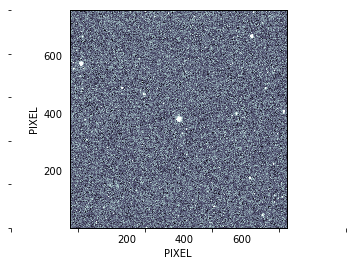

In [132]:
fig, ax = plt.subplots()
# ax.xaxis.set_ticks_position('none')
# ax.yaxis.set_ticks_position('none')
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.spines["top"].set_visible(False)
ax.spines["bottom"].set_visible(False)
ax.spines["left"].set_visible(False)
ax.spines["right"].set_visible(False)

ax = aplpy.FITSFigure(co.data, figure=fig, projection=co.wcs)
ax.show_colorscale(cmap='bone', stretch='linear', vmid=None)

ax.ticks.show()
ax.tick_labels.show()
# ax.ticks.set_xspacing(.01)

ax.set_xaxis_coord_type('scalar')
ax.set_yaxis_coord_type('scalar')
# ax.tick_labels.set_xformat('ddd.dddd')
# ax.tick_labels.set_yformat('ddd.dddd')
# ax.ticks.hide()
ax.ticks.set_minor_frequency(10)

plt.show()

In [ ]:
ax.tick_labels.set_format?

In [ ]:
print SkyCoord(RA*u.deg, DEC*u.deg, frame='icrs')